In [95]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/test/8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2100032a-7c33-4bff-97ef-690822c43466.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2f392438-e215-4169-bebf-21ac4ff253e1.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/3f316b38-1a24-45a9-8d8c-4e05a42257c6.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/f8b03c87-9d1a-4f20-b76b-cb6c69d447b2.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/585ba241-6348-41ce-a5d2-c9ee434cd64d.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/bde73ad6-ce46-489b-8ee0-b162698cc6df.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/c7ce1ac6-36e4-4258-b2e4-1b525dc82ad5.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/9d75e205-3030-44c6-ae

# Libraries

In [96]:
import pandas as pd
import numpy as np
import random
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import re
import json
from tqdm.autonotebook import tqdm
import string

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import utils
from keras.models import *
from keras.layers import *
from keras.callbacks import *

from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')

In [97]:
#define stopwords
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

# OBTAIN

In [98]:
#read train data
train_df = pd.read_csv('../input/flatiron-capstone-project/train_df.csv', index_col = 0)
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this study used data from the national educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,stress satisfactory outcomes for all youth inc...
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,federal reserve bank of richmond s1 accounting...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this article investigates an important factor ...


In [99]:
#read submission data
submission_df = pd.read_csv('../input/flatiron-capstone-project/submission.csv', index_col = 0)
submission_df.head()

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,NaN,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN,"Cape Hatteras National Seashore (CAHA), locate..."
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN,A significant body of research has been conduc...


Now, our job is to fill in the column 'PredictionString' with cleaned_label that matches the given text.

# STRING MATCHING

In [100]:
#create a knowledge bank
dataset_label = [x.lower() for x in train_df['dataset_label'].unique()]
dataset_title = [x.lower() for x in train_df['dataset_title'].unique()]
cleaned_label = [x.lower() for x in train_df['cleaned_label'].unique()]

existing_labels = set(dataset_label + dataset_title + cleaned_label)

In [101]:
print(f'dataset_label = {len(dataset_label)}')
print(f'dataset_title = {len(dataset_title)}')
print(f'cleaned_label = {len(cleaned_label)}')
print(f'No. different labels: {len(existing_labels)}')

dataset_label = 130
dataset_title = 45
cleaned_label = 130
No. different labels: 180


In [102]:
existing_labels

{'2019 ncov complete genome sequences',
 '2019 ncov genome sequence',
 '2019 ncov genome sequences',
 '2019-ncov complete genome sequences',
 '2019-ncov genome sequence',
 '2019-ncov genome sequences',
 'adni',
 'advanced national seismic system (anss) comprehensive catalog (comcat)',
 'advanced national seismic system anss comprehensive catalog comcat ',
 'advanced national seismic system comprehensive catalog',
 'aging integrated database',
 'aging integrated database (agid)',
 'aging integrated database agid ',
 'agricultural resource management survey',
 'agricultural resources management survey',
 'alzheimer s disease neuroimaging initiative adni ',
 "alzheimer's disease neuroimaging initiative (adni)",
 'alzheimers disease neuroimaging initiative',
 'anss comprehensive catalog',
 'anss comprehensive earthquake catalog',
 'arms farm financial and crop production practices',
 'baccalaureate and beyond',
 'baccalaureate and beyond longitudinal study',
 'baltimore longitudinal study 

Match 'Id' and 'text' with 'cleaned_label'

In [103]:
def text_cleaning(text):
    '''
    Converts all text to lower case, Removes special charecters, emojis and multiple spaces
    text - Sentence that needs to be cleaned
    '''
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    text = re.sub(' +', ' ', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [104]:
id_list = []
lables_list = []
for index, row in tqdm(submission_df.iterrows()):
    sample_text = row['text']
    row_id = row['Id']
    temp_df = train_df[train_df['text'] == text_cleaning(sample_text)]
    cleaned_labels = temp_df['cleaned_label'].to_list()
    
    for known_label in existing_labels:
        if known_label in sample_text.lower():
            cleaned_labels.append(text_cleaning(known_label))
            
    cleaned_labels = [text_cleaning(x) for x in cleaned_labels]
    cleaned_labels = set(cleaned_labels)
    lables_list.append(' | '.join(cleaned_labels))
    id_list.append(row_id)

0it [00:00, ?it/s]

In [105]:
#string matching
submission_df['PredictionString'] = lables_list

#review
submission_df.head()

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,alzheimer s disease neuroimaging initiative ad...,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,nces common core of data | common core of data...,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,noaa storm surge inundation | sea lake and ove...,"Cape Hatteras National Seashore (CAHA), locate..."
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes,A significant body of research has been conduc...


In [106]:
#check out first prediction
submission_df['PredictionString'][:1]

0    alzheimer s disease neuroimaging initiative ad...
Name: PredictionString, dtype: object

We see that with the provided text, 2 datasets are identified: 'adni' and 'alzheimer s disease neuroimaging...'

In [107]:
#save
submission_df.to_csv('string_matching_submission.csv')

# CLASSIFIERS: RandomForestClassifier, SVC, MultinomialNB

## Preprocessing

Preprocessing text data is a bit more challenging that working with more traditional data types because there's no clear-cut answer for exactly what sort of preprocessing and cleaning we need to do. Before we can begin cleaning and preprocessing our text data, we need to make some decisions about things such as:

* Do we remove stop words or not?
* Do we stem or lemmatize our text data, or leave the words as is?
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

### Count Vectorization

Machine Learning algorithms don't understand strings. However, they do understand math, which means they understand vectors and matrices. By Vectorizing the text, we just convert the entire text into a vector, where each element in the vector represents a different word. The vector is the length of the entire vocabulary -- usually, every word that occurs in the English language, or at least every word that appears in our corpus. Any given sentence can then be represented as a vector where all the vector is 1 (or some other value) for each time that word appears in the sentence.

### TD-IDF Vectorization

TD-IDF is short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

**Count Vectorizer give number of frequency with respect to index of vocabulary where as tf-idf consider overall documents of weight of words.**

### Word Count

In [108]:
#word count
print('Word count in dataset_title', train_df['dataset_title'].apply(lambda x: len(x.split(' '))).sum())
print('Word count in cleaned_label', train_df['cleaned_label'].apply(lambda x: len(x.split(' '))).sum())
print('Word count in text', train_df['text'].apply(lambda x: len(x.split(' '))).sum())

Word count in dataset_title 93085
Word count in cleaned_label 82930
Word count in text 171851448


### Train-Test-Split

In [109]:
X = train_df['dataset_title'].to_numpy()
y = train_df['cleaned_label'].to_numpy()

#split traing data into training a validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [110]:
#check shape
print('Train sentences:', X_train.shape, '\n', 
      'Test sentences:', X_test.shape, '\n', 
      'Train labels:', y_train.shape, '\n', 
      'Test labels:', y_test.shape)

Train sentences: (15728,) 
 Test sentences: (3933,) 
 Train labels: (15728,) 
 Test labels: (3933,)


In [111]:
# find avg # of takens (words) in the training set
round(sum([len(i.split()) for i in X_train]) / len(X_train))

5

In [112]:
#from imblearn.over_sampling import SMOTE

#previous original class distribution
#print('Class Distribution Before:')
#print('Train Set')
#print(y_train.value_counts())

#fit
#smote = SMOTE()
#X_train, y_train = smote.fit_resample(X_train, y_train)

#check class distribution
#print('\n')
#print('Class Distribution After:')
#print('Train Set')
#print(y_train.value_counts())

## Random Forest

In [113]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

#create a tokenization a modelling pipeline
RandomForestClassifier_model = Pipeline([('tfidf', TfidfVectorizer(min_df = 3,
                                                                   max_features = None,
                                                                   strip_accents = 'unicode',
                                                                   analyzer = 'word',
                                                                   token_pattern = r'\w{1,}',
                                                                   ngram_range = (1, 3),
                                                                   use_idf = 1,
                                                                   smooth_idf = 1,
                                                                   sublinear_tf = 1,
                                                                   stop_words = stopwords_list)), #convert words to munbers using tfid
                                         ('clf', RandomForestClassifier(n_estimators = 100, random_state = 123))]) #model the text

#fit the pipeline to the training data
RandomForestClassifier_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode', sublinear_tf=1,
                                 token_pattern='\\w{1,}', use_idf=1)),
                ('clf', RandomForestClassifier(random_state=123))])

In [114]:
#predict 
RandomForestClassifier_yhat_train = RandomForestClassifier_model.predict(X_train)
RandomForestClassifier_yhat_test = RandomForestClassifier_model.predict(X_test)

#train accuracy 
RandomForestClassifier_train_accuracy = accuracy_score(y_train, RandomForestClassifier_yhat_train) * 100
print('Train accuracy: {0}'.format(RandomForestClassifier_train_accuracy))

#test accuracy 
RandomForestClassifier_test_accuracy = accuracy_score(y_test, RandomForestClassifier_yhat_test) * 100
print('Test accuracy: {0}'.format(RandomForestClassifier_test_accuracy))

Train accuracy: 74.57400813835199
Test accuracy: 74.57411645054665


In [115]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

#get classification report
print('Model: RandomForestClassifier', '\n', classification_report(y_test, RandomForestClassifier_yhat_test))

Model: RandomForestClassifier 
                                                                                                       precision    recall  f1-score   support

                                                                           2019 ncov genome sequence       0.00      0.00      0.00         1
                                                                          2019 ncov genome sequences       0.00      0.00      0.00         2
                                                                                                adni       0.58      1.00      0.74       709
                                 advanced national seismic system anss comprehensive catalog comcat        0.00      0.00      0.00         2
                                                             agricultural resource management survey       0.94      1.00      0.97       127
                                                            agricultural resources management survey       0.00    

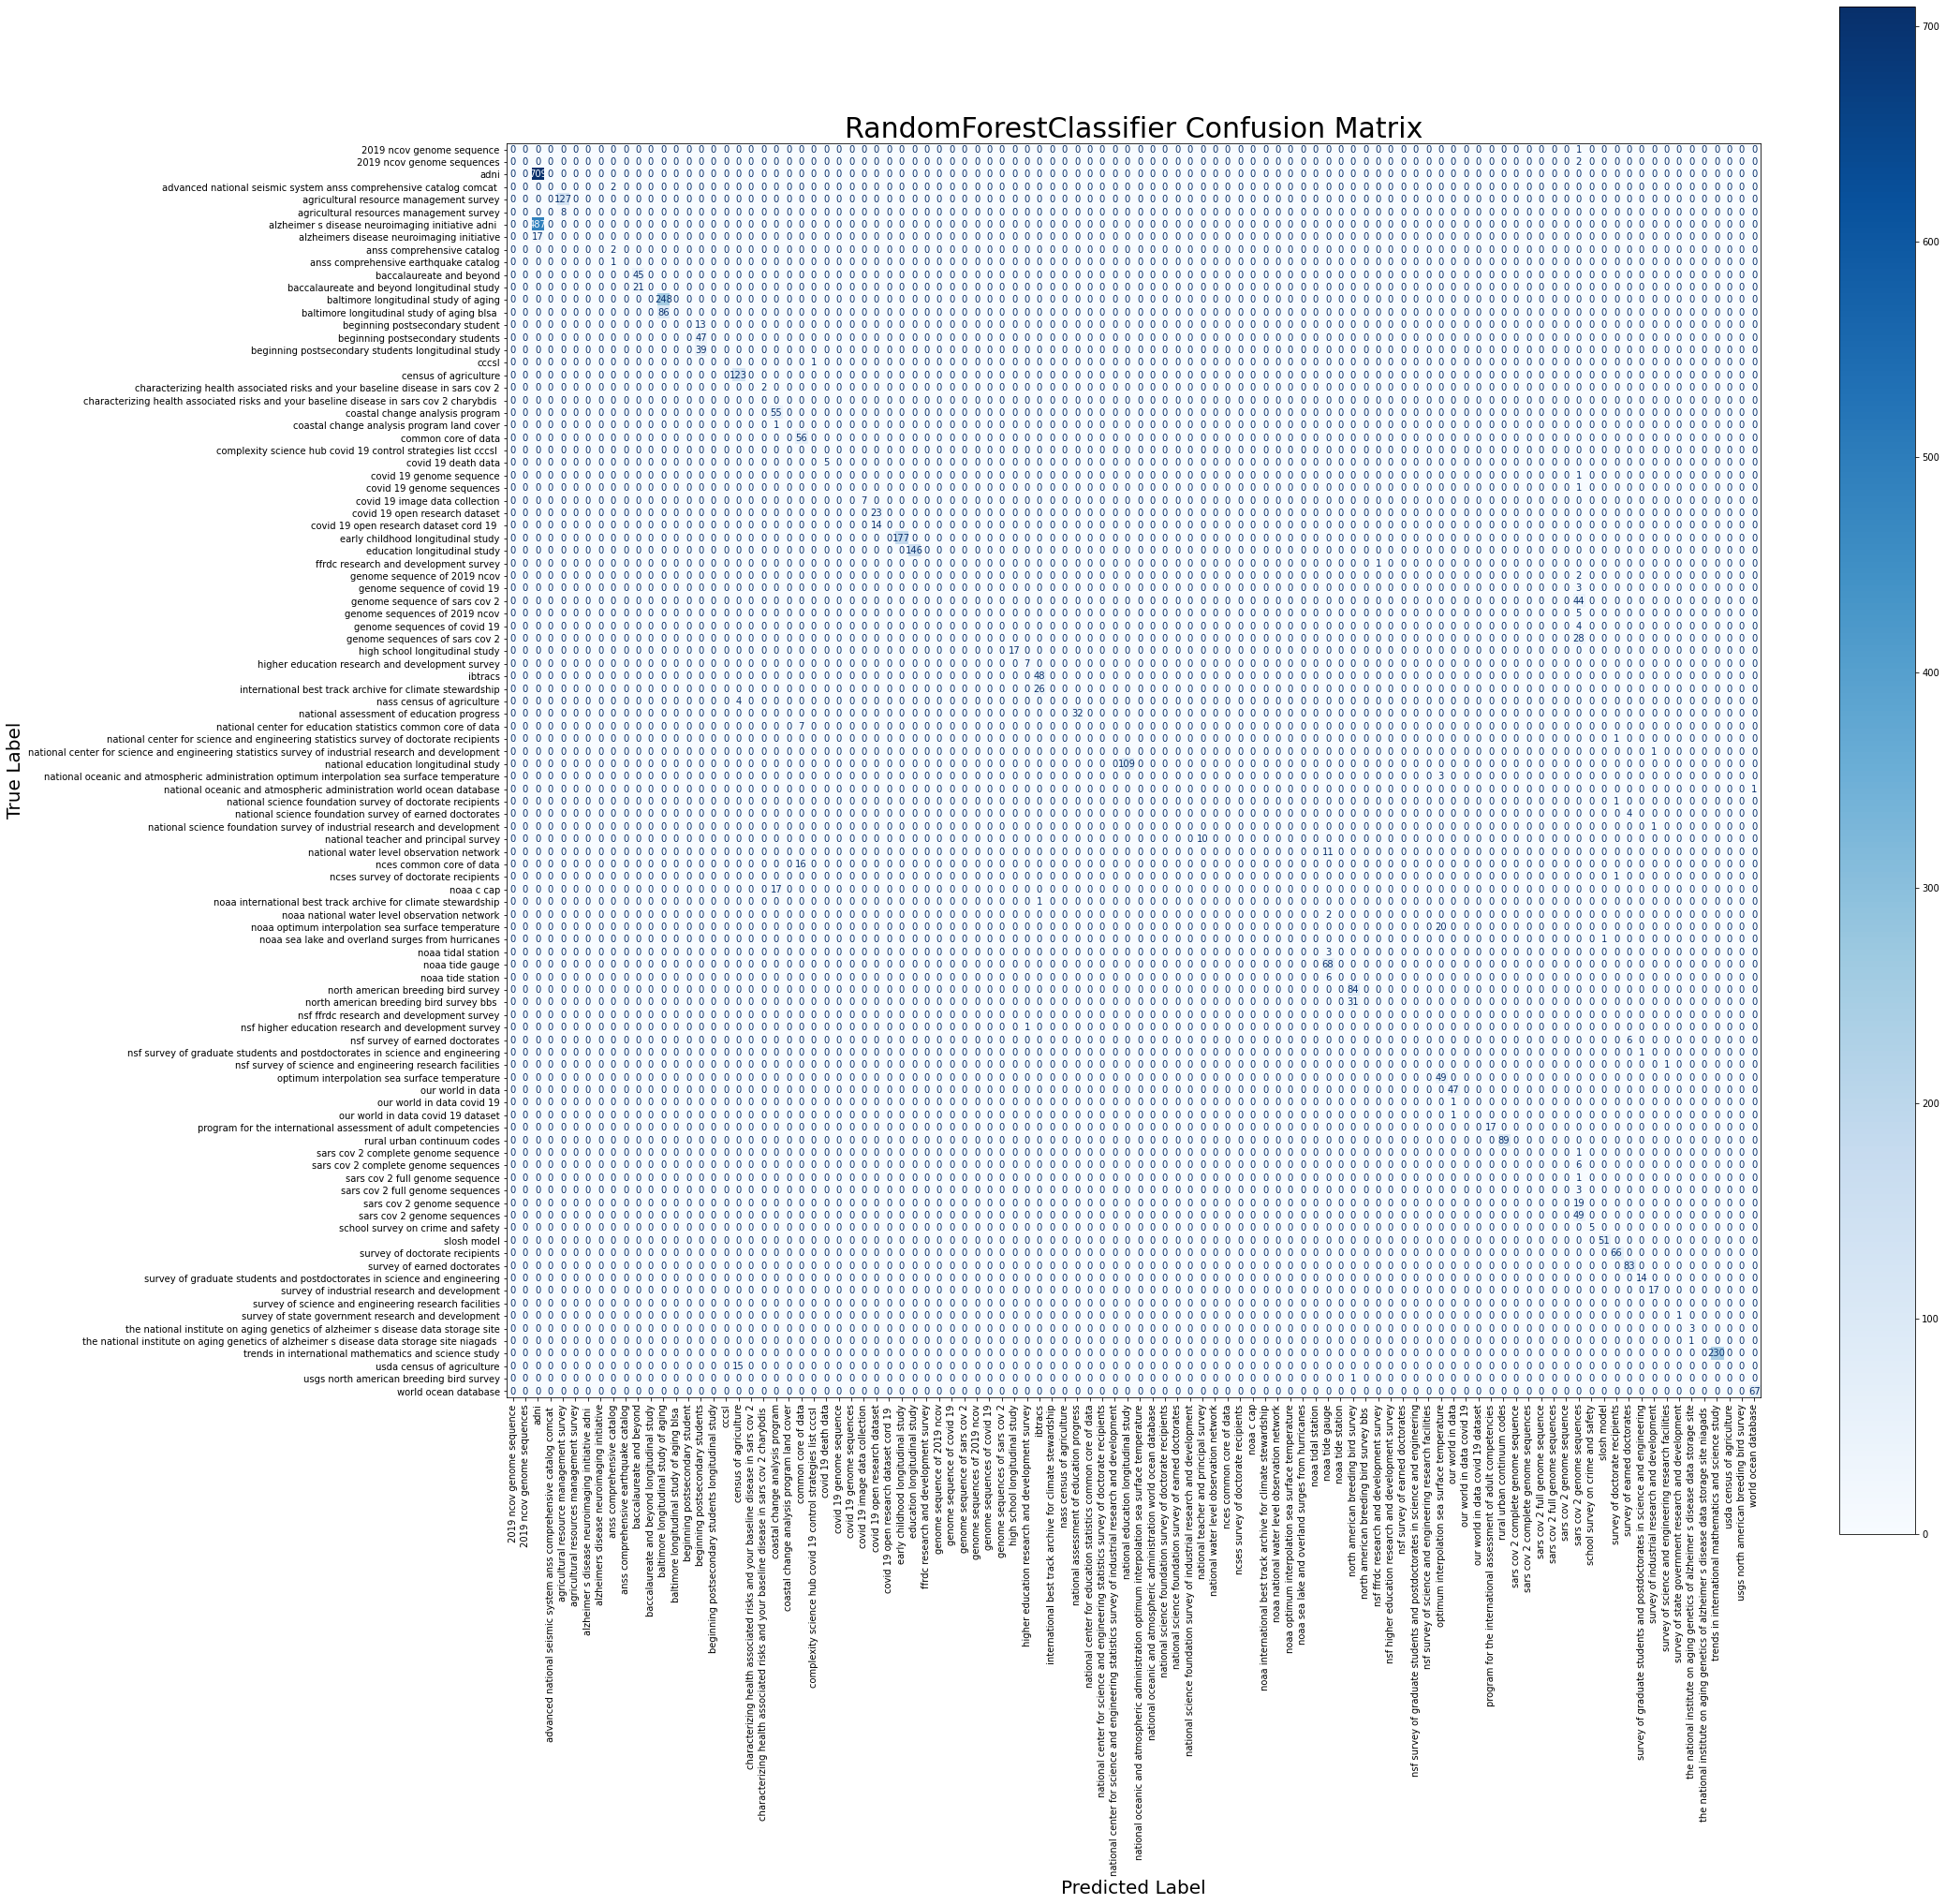

In [116]:
from sklearn.metrics import plot_confusion_matrix

#plot confusion matrix
fig, ax = plt.subplots(figsize = (30, 30))
plot_confusion_matrix(RandomForestClassifier_model, X_test, y_test, cmap = plt.cm.Blues, ax = ax) 
plt.title('RandomForestClassifier Confusion Matrix', fontsize = 30)
plt.ylabel('True Label', fontsize = 20)
plt.xlabel('Predicted Label', fontsize = 20)
plt.xticks(rotation = 90);

#save
plt.savefig('RandomForestClassifier_cm.png')

In [134]:
#generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(5):
    prediction = RandomForestClassifier_model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(train_df['dataset_title'].iloc[i][:50], '...')
    print('Actual label: ' + train_df['cleaned_label'].iloc[i])
    print('Predicted label: ' + predicted_label + '\n')

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences



In [117]:
#summary table
summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [],
                              'Precision': [], 'Recall': [], 'F1': []})

In [118]:
summary_table.loc[0] = ['CLF RandomForestClassifier',
                        round(accuracy_score(y_test, RandomForestClassifier_yhat_test), 2),
                        round(precision_score(y_test, RandomForestClassifier_yhat_test, average = 'macro'), 2), 
                        round(recall_score(y_test, RandomForestClassifier_yhat_test, average = 'macro'), 2), 
                        round(f1_score(y_test, RandomForestClassifier_yhat_test, average = 'macro'), 2)]
summary_table.head()

,Model,Accuracy,Precision,Recall,F1
0,CLF RandomForestClassifier,0.75,0.31,0.37,0.33


## Linear Support Vector Machine

In [119]:
from sklearn.linear_model import SGDClassifier

#create a tokenization a modelling pipeline
SGDClassifier_model = Pipeline([('tfidf', TfidfVectorizer(min_df = 3,
                                                max_features = None,
                                                strip_accents = 'unicode',
                                                analyzer = 'word',
                                                token_pattern = r'\w{1,}',
                                                ngram_range = (1, 3),
                                                use_idf = 1,
                                                smooth_idf = 1,
                                                sublinear_tf = 1,
                                                stop_words = stopwords_list)), #convert words to munbers using tfid
                                ('clf', SGDClassifier(loss = 'hinge', #use Linear SVC(SVM) model when the parameter loss is set to 'hinge'
                                                      penalty = 'l2',
                                                      alpha = 1e-3,
                                                      random_state = 123,
                                                      max_iter = 5))]) #model the text

#fit the pipeline to the training data
SGDClassifier_model.fit(X_train, y_train) 

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode', sublinear_tf=1,
                                 token_pattern='\\w{1,}', use_idf=1)),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=123))])

In [120]:
#predict 
SGDClassifier_yhat_train = SGDClassifier_model.predict(X_train)
SGDClassifier_yhat_test = SGDClassifier_model.predict(X_test)

#train accuracy 
SGDClassifier_train_accuracy = accuracy_score(y_train, SGDClassifier_yhat_train) * 100
print('Train accuracy: {0}'.format(SGDClassifier_train_accuracy))

#test accuracy 
SGDClassifier_test_accuracy = accuracy_score(y_test, SGDClassifier_yhat_test) * 100
print('Test accuracy: {0}'.format(SGDClassifier_test_accuracy))

Train accuracy: 74.42777212614445
Test accuracy: 74.42156114924994


In [121]:
#get classification report
print('Model: Support Vector Machine', '\n', classification_report(y_test, SGDClassifier_yhat_test))

Model: Support Vector Machine 
                                                                                                       precision    recall  f1-score   support

                                                                           2019 ncov genome sequence       0.00      0.00      0.00         1
                                                                          2019 ncov genome sequences       0.00      0.00      0.00         2
                                                                                                adni       0.58      1.00      0.74       709
                                 advanced national seismic system anss comprehensive catalog comcat        0.00      0.00      0.00         2
                                                             agricultural resource management survey       0.94      1.00      0.97       127
                                                            agricultural resources management survey       0.00    

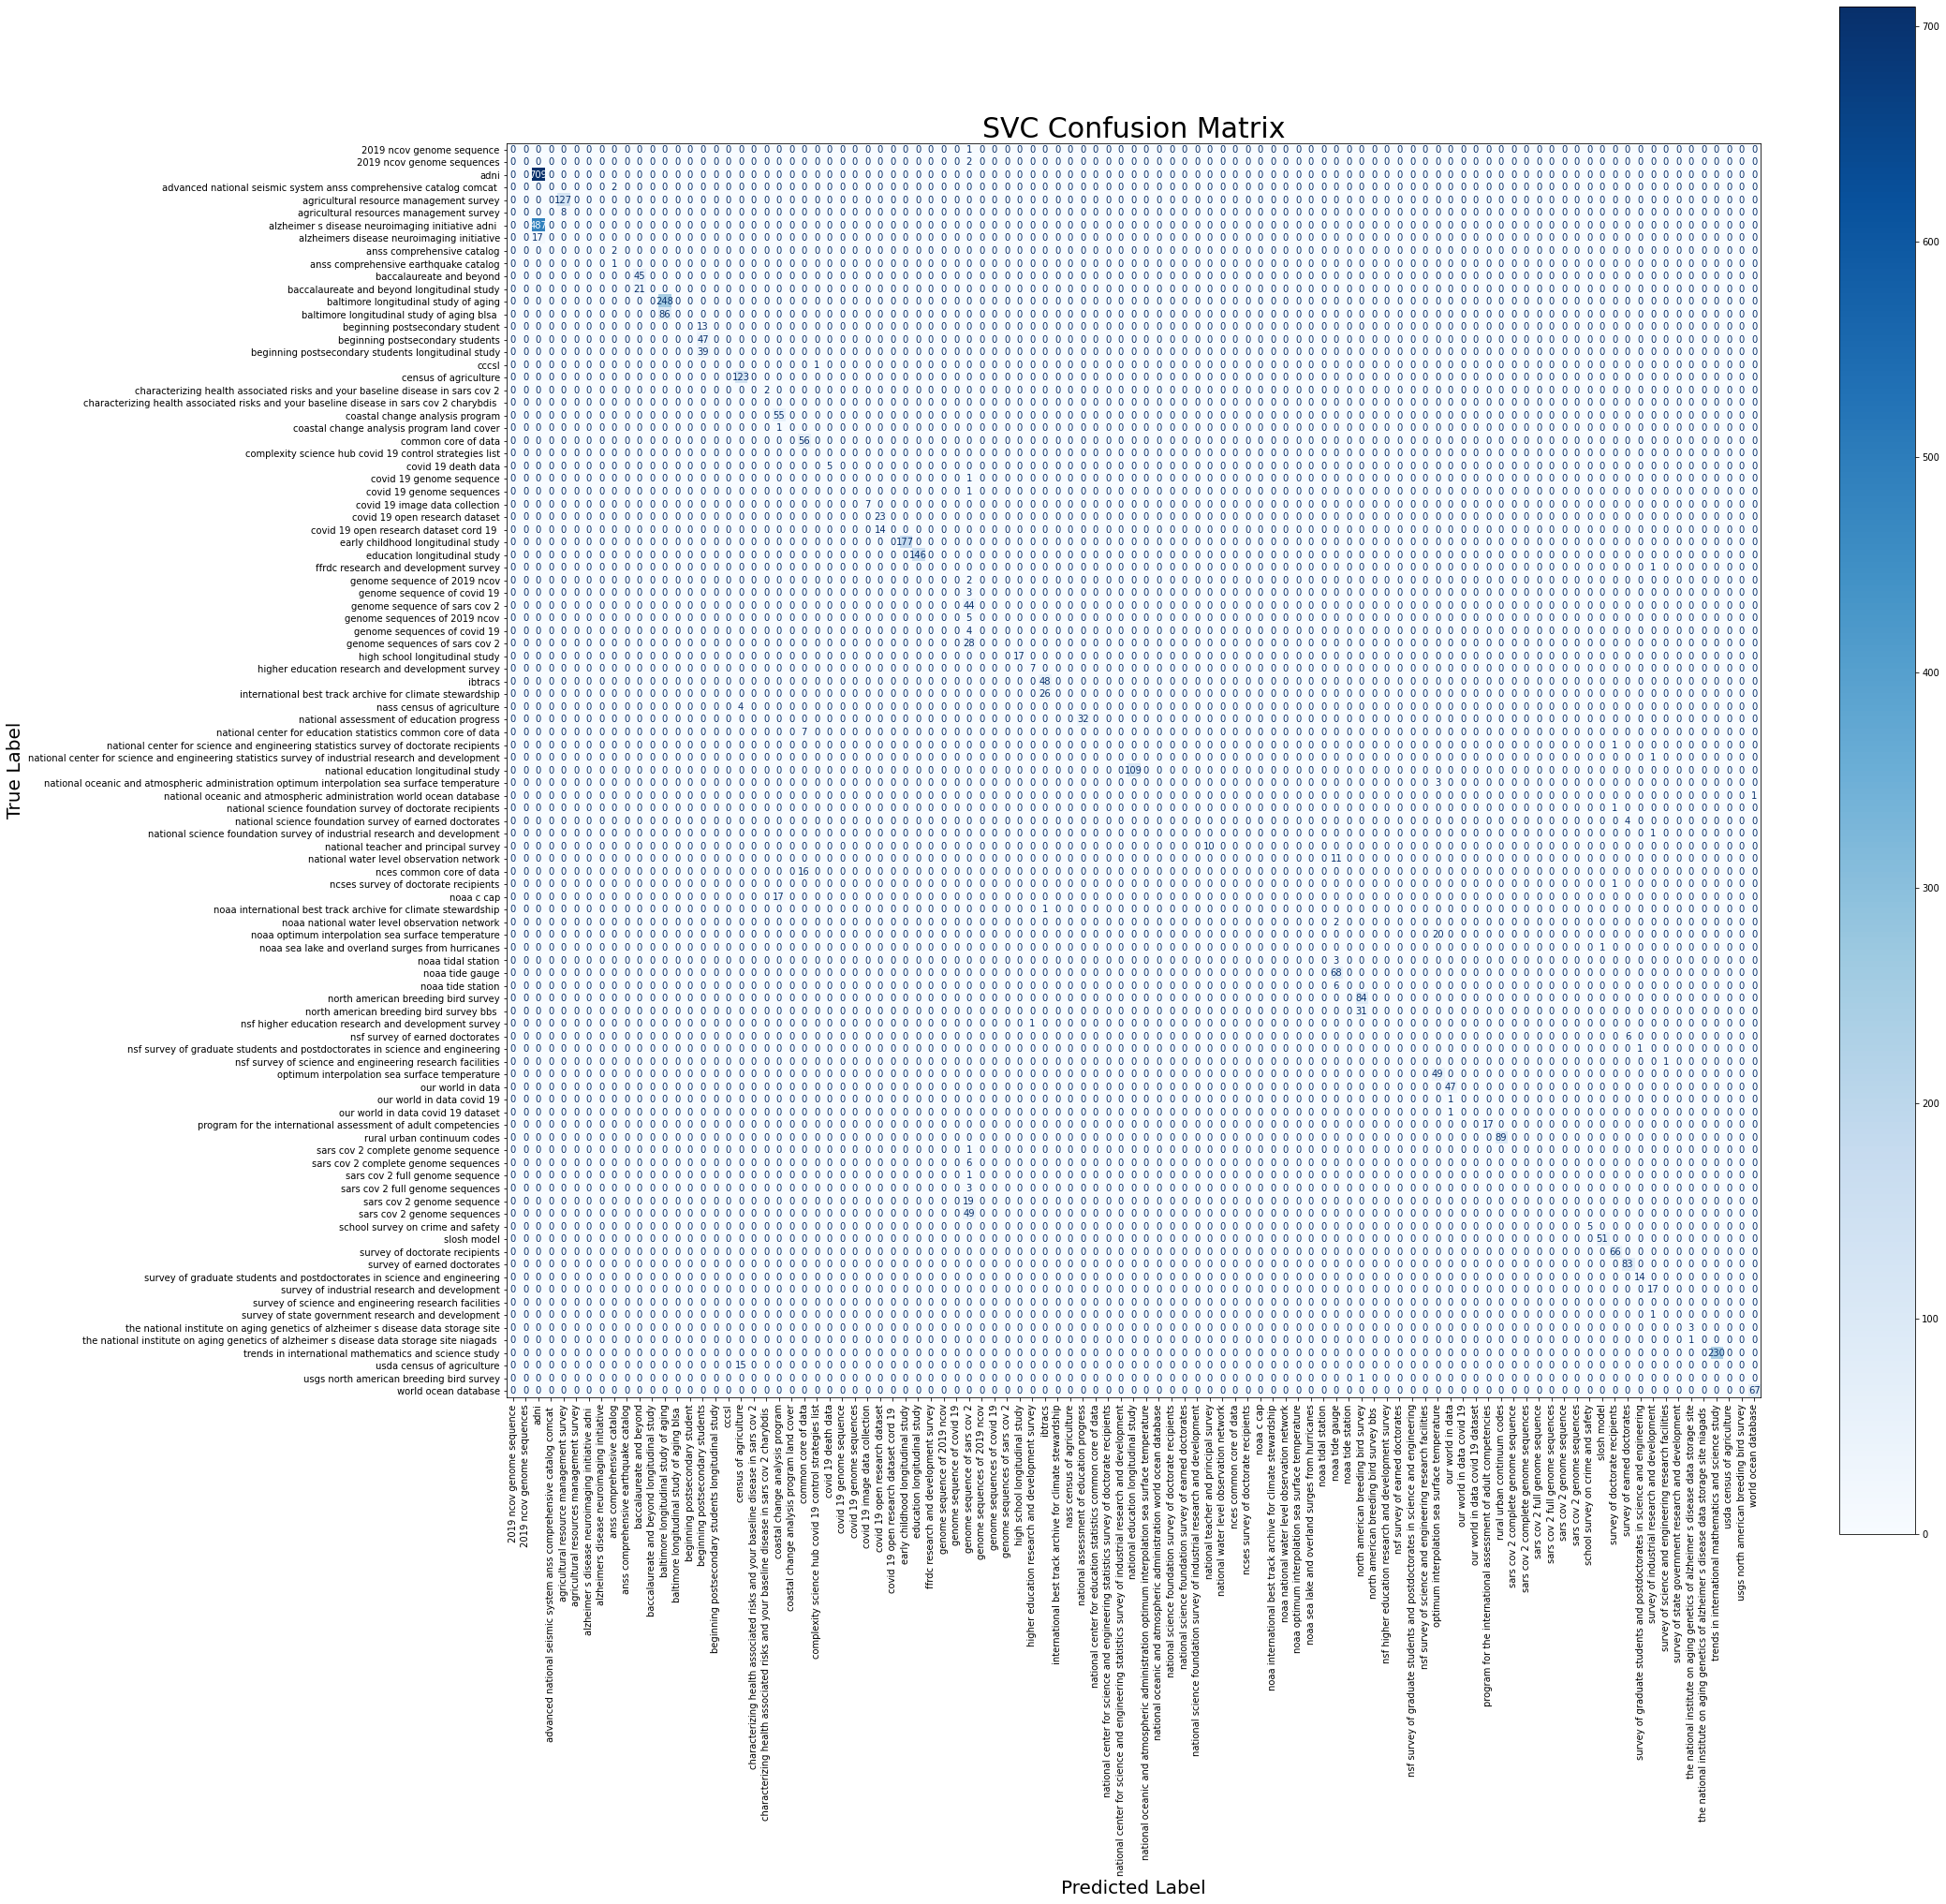

In [122]:
fig, ax = plt.subplots(figsize = (30, 30))
plot_confusion_matrix(SGDClassifier_model, X_test, y_test, cmap = plt.cm.Blues, ax = ax) 
plt.title('SVC Confusion Matrix', fontsize = 30)
plt.ylabel('True Label', fontsize = 20)
plt.xlabel('Predicted Label', fontsize = 20)
plt.xticks(rotation = 90);

#save
plt.savefig('SVC_cm.png')

In [133]:
#generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(5):
    prediction = SGDClassifier_model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(train_df['dataset_title'].iloc[i][:50], '...')
    print('Actual label: ' + train_df['cleaned_label'].iloc[i])
    print('Predicted label: ' + predicted_label + '\n')

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences



In [123]:
summary_table.loc[1] = ['CLF Linear Support Vector Machine',
                        round(accuracy_score(y_test, SGDClassifier_yhat_test), 2),
                        round(precision_score(y_test, SGDClassifier_yhat_test, average = 'macro'), 2), 
                        round(recall_score(y_test, SGDClassifier_yhat_test, average = 'macro'), 2), 
                        round(f1_score(y_test, SGDClassifier_yhat_test, average = 'macro'), 2)]
summary_table.head()

,Model,Accuracy,Precision,Recall,F1
0,CLF RandomForestClassifier,0.75,0.31,0.37,0.33
1,CLF Linear Support Vector Machine,0.74,0.30,0.36,0.33


# Naive Bayes MultinomialNB

In [124]:
from sklearn.naive_bayes import MultinomialNB

#create a tokenization a modelling pipeline
MultinomialNB_model = Pipeline([('tfidf', TfidfVectorizer(min_df = 3,  
                                                          max_features = None,
                                                          strip_accents = 'unicode', 
                                                          analyzer = 'word',
                                                          token_pattern = r'\w{1,}',
                                                          ngram_range = (1, 3), 
                                                          use_idf = 1,
                                                          smooth_idf = 1,
                                                          sublinear_tf = 1,
                                                          stop_words = stopwords_list)), #convert words to munbers using tfid
                                ('clf', MultinomialNB())]) #model the text

#fit the pipeline to the training data
MultinomialNB_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode', sublinear_tf=1,
                                 token_pattern='\\w{1,}', use_idf=1)),
                ('clf', MultinomialNB())])

In [125]:
#predict 
MultinomialNB_yhat_train = MultinomialNB_model.predict(X_train)
MultinomialNB_yhat_test = MultinomialNB_model.predict(X_test)

#train accuracy 
MultinomialNB_train_accuracy = accuracy_score(y_train, MultinomialNB_yhat_train) * 100
print('Train accuracy: {0}'.format(MultinomialNB_train_accuracy))

#test accuracy 
MultinomialNB_test_accuracy = accuracy_score(y_test, MultinomialNB_yhat_test) * 100
print('Test accuracy: {0}'.format(MultinomialNB_test_accuracy))

Train accuracy: 74.49771108850459
Test accuracy: 74.5486905669972


In [126]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

#get classification report
print('Model: MultinomialNB', '\n', classification_report(y_test, MultinomialNB_yhat_test))

Model: MultinomialNB 
                                                                                                       precision    recall  f1-score   support

                                                                           2019 ncov genome sequence       0.00      0.00      0.00         1
                                                                          2019 ncov genome sequences       0.00      0.00      0.00         2
                                                                                                adni       0.58      1.00      0.74       709
                                 advanced national seismic system anss comprehensive catalog comcat        0.00      0.00      0.00         2
                                                             agricultural resource management survey       0.94      1.00      0.97       127
                                                            agricultural resources management survey       0.00      0.00   

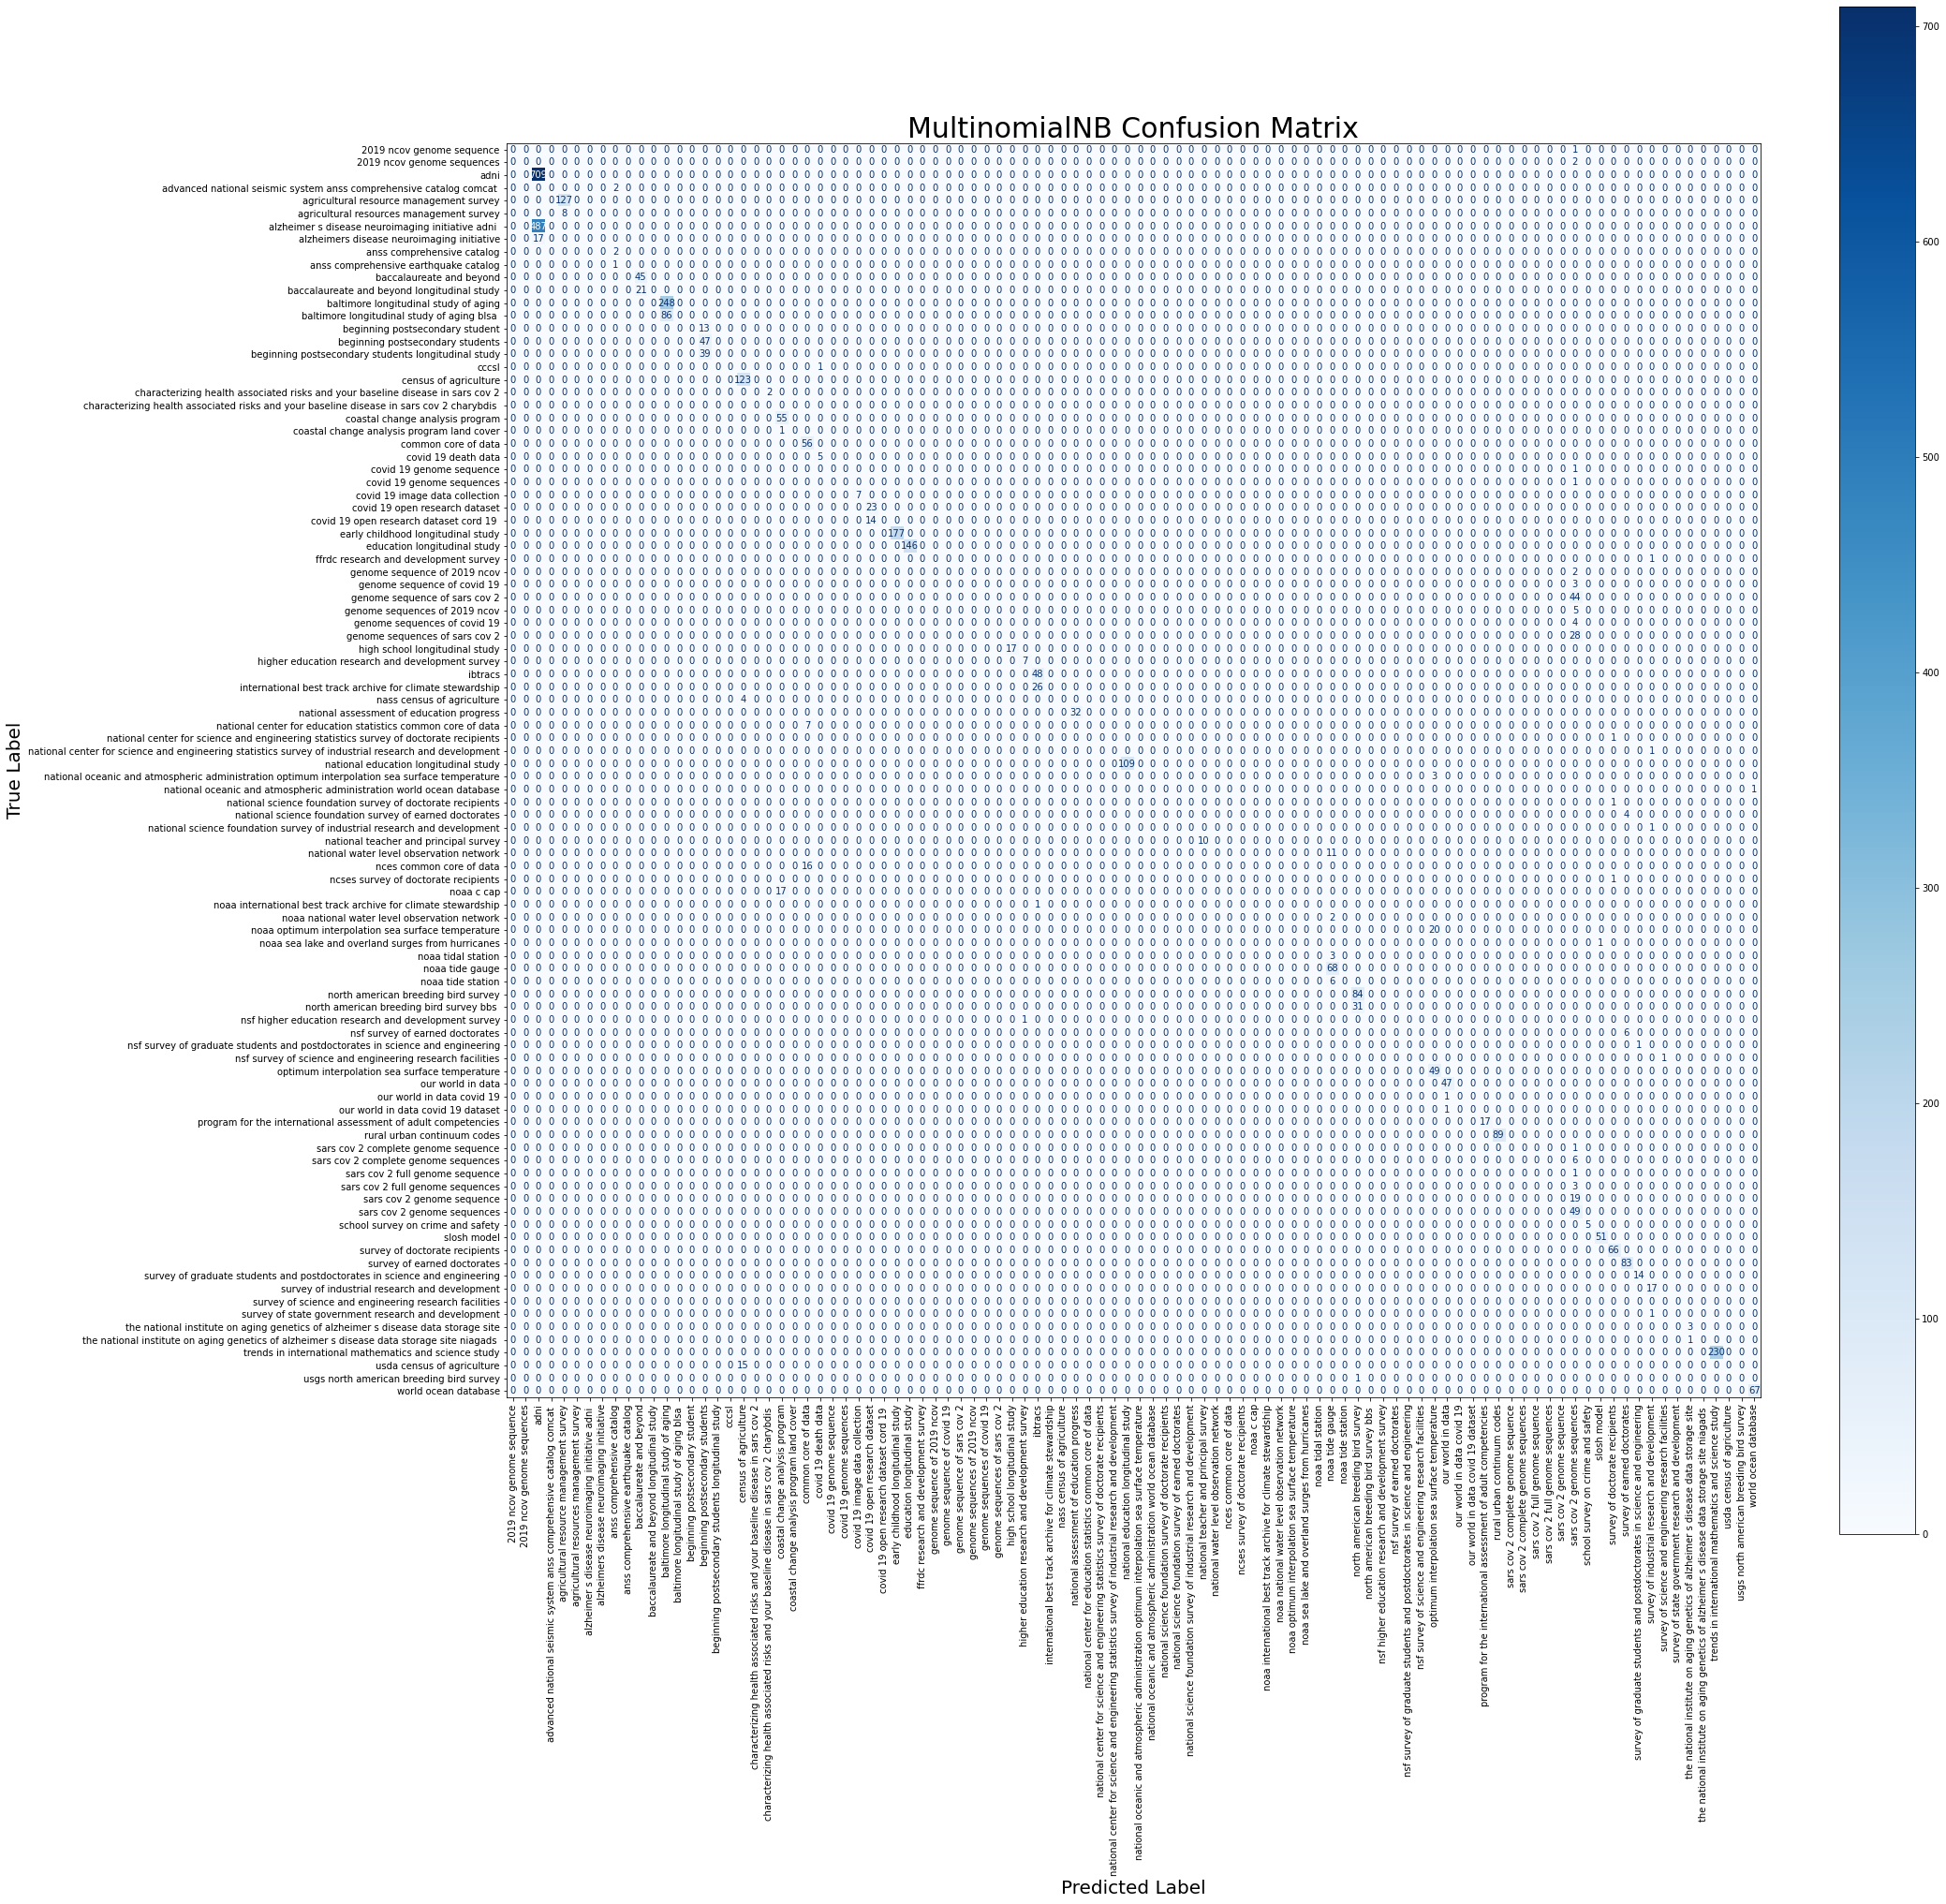

In [127]:
#plot confusion matrix
fig, ax = plt.subplots(figsize = (30, 30))
plot_confusion_matrix(MultinomialNB_model, X_test, y_test, cmap = plt.cm.Blues, ax = ax) 
plt.title('MultinomialNB Confusion Matrix', fontsize = 30)
plt.ylabel('True Label', fontsize = 20)
plt.xlabel('Predicted Label', fontsize = 20)
plt.xticks(rotation = 90);

#save
plt.savefig('MultinomialNB_cm.png')

In [132]:
#generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(5):
    prediction = MultinomialNB_model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(train_df['dataset_title'].iloc[i][:50], '...')
    print('Actual label: ' + train_df['cleaned_label'].iloc[i])
    print('Predicted label: ' + predicted_label + '\n')

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences



In [128]:
#update summary table
summary_table.loc[2] = ['CLF MultinomialNB',
                        round(accuracy_score(y_test, MultinomialNB_yhat_test), 2),
                        round(precision_score(y_test, MultinomialNB_yhat_test, average = 'macro'), 2), 
                        round(recall_score(y_test, MultinomialNB_yhat_test, average = 'macro'), 2), 
                        round(f1_score(y_test, MultinomialNB_yhat_test, average = 'macro'), 2)]
summary_table.head()

,Model,Accuracy,Precision,Recall,F1
0,CLF RandomForestClassifier,0.75,0.31,0.37,0.33
1,CLF Linear Support Vector Machine,0.74,0.30,0.36,0.33
2,CLF MultinomialNB,0.75,0.30,0.37,0.33


# INTERPRETATION

In [ ]:
y_hats = MultinomialNB_model.predict(X_test)

y_hats  = pd.DataFrame(y_hats)

df_out = X_test.reset_index()
df_out["Actual"] = y_test.reset_index()["Columns_Name"]
df_out["Prediction"] = y_hats.reset_index()[0]


y_test['preds'] = y_hats

df_out = pd.merge(df,y_test[['preds']],how = 'left',left_index = True, right_index = True)